# Load weights from TF model

*Note: A kernel with tf 1 is needed*

### Download pre-trained models

In [2]:
# from https://github.com/tensorflow/tpu/blob/master/models/official/mnasnet/mnasnet_example.ipynb

from IPython import display
display.clear_output()


checkpoint_name = 'mnasnet-a1' #@param
url = 'https://storage.googleapis.com/mnasnet/checkpoints/' + checkpoint_name + '.tar.gz'
print('Downloading from ', url)

!wget -nc {url}
print('Unpacking')
!tar -xvf {checkpoint_name}.tar.gz

display.clear_output()
print('Successfully downloaded checkpoint from ', url,
      '.\nIt is available as', checkpoint_name)

Successfully downloaded checkpoint from  https://storage.googleapis.com/mnasnet/checkpoints/mnasnet-a1.tar.gz .
It is available as mnasnet-a1


### Load model

In [3]:
import os
import tensorflow as tf

export_dir = os.path.join(checkpoint_name, 'saved_model')

with tf.Graph().as_default() as graph, tf.Session() as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_dir)

    vars_global = tf.global_variables()
    model_vars = {}    
    # get their name and value and put them into dictionary
    sess.as_default()
    for var in vars_global:
        try:
            model_vars[var.name] = var.eval()
        except:
            print("For var={}, an exception occurred".format(var.name))

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from mnasnet-a1/saved_model/variables/variables


### Save weights

In [4]:
import numpy as np

np.save("tf_weights.npy", model_vars)
!rm {checkpoint_name}.tar.gz
!rm -rf {checkpoint_name}

# Transfer weights to TF2 keras model

*Note: A kernel with tf 2 is needed*

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np

tf_weights = np.load('tf_weights.npy', allow_pickle=True).item()

In [3]:
from MnasNet_models import Build_MnasNet

model = Build_MnasNet('a1')

In [4]:
def verify_and_set(layer, block_id, tf_weights, tf_keys, curr_index, verbose):
    name = layer.name
    start = 'mnasnet-a1'
    block_name = f'mnas_blocks_{block_id}'
    
    if name.endswith('depthwise_conv'):
        key = '{}/mnas_net_model/{}/depthwise_conv2d'.format(start, block_name)
        forward = 1
    
    elif name.endswith('se_reduce_conv') or name.endswith('se_expand_conv'):
        key = '{}/mnas_net_model/{}/se/conv2d'.format(start, block_name)
        forward = 2
    
    elif name.endswith('stem_conv') or name.endswith('head_conv'):
        key = '{}/mnas_net_model/mnas_{}/conv2d'.format(start, name[:4])
        forward = 1
    
    elif name.endswith('stem_conv'):
        key = '{}/mnas_net_model/mnas_stem/conv2d'.format(start)
        forward = 1
    
    elif name.endswith('conv'):
        key = '{}/mnas_net_model/{}/conv2d'.format(start, block_name)
        forward = 1

    elif name.endswith('stem_conv_BN') or name.endswith('head_conv_BN'):
        key = '{}/mnas_{}/batch_normalization'.format(start, name[:4])
        forward = 4

    elif name.endswith('BN'):
        key = '{}/{}/batch_normalization'.format(start, block_name)
        forward = 4
    
    elif name.startswith('FC'):
        key = '{}/mnas_net_model/mnas_head/dense'.format(start)
        forward = 2

    else:
        if layer.variables != []:
            raise ValueError(f'Layer "{name}" is not supported')
        return curr_index
    
    weights = []
    for i in range(curr_index, curr_index+forward):
        if not tf_keys[i].startswith(key):
            msg = 'For layer={}, an exception occurred\n'
            msg += "\ttf_index:\t{}\n\taccess_key:\t{}\n\treal_key:\t{}"
            raise ValueError(msg.format(name, i, key, tf_keys[i]))
        weights.append(tf_weights[tf_keys[i]])
    layer.set_weights(weights)  

    if verbose:
        print(f'Processesd "{name}"')
    return curr_index+forward


def keras_set_weights_from_tf_model(model, tf_weights, verbose=False):
    tf_index = 1
    block_id = 0
    b_chars = ('0',) * 2
    tf_keys = list(tf_weights.keys())
    
    for layer in model.layers:
        name = layer.name
        if name.startswith('block'):
            if b_chars != (name[6], name[12]):
                block_id += 1
                b_chars = (name[6], name[12])
        
        tf_index = verify_and_set(
            layer,
            block_id,
            tf_weights,
            tf_keys,
            tf_index,
            verbose
            )      

In [5]:
keras_set_weights_from_tf_model(model, tf_weights)

In [13]:
model.save_weights('MnasNet_tf2_keras.h5')
!rm tf_weights.npy

# Evaluate

In [7]:
!wget -nc -q https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG -O panda.jpg

In [8]:
!wget -nc -q https://aarp-content.brightspotcdn.com/dims4/default/e7e2963/2147483647/strip/true/crop/300x290+0+0/resize/300x290!/quality/90/?url=https%3A%2F%2Faarp-content.brightspotcdn.com%2F98%2F1c%2Fdfac6ce8356337da01ab12df467c%2Fistock-000000394610medium-e1422385829283-300x290.jpg -O tpaper.jpg

In [9]:
from IPython import display
from PIL import Image
import numpy as np
filename = 'panda.jpg'
img = np.array(Image.open(filename).resize((224, 224))).astype(np.float)

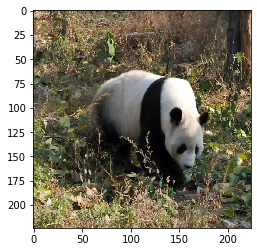

In [10]:
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(img / 255)

In [14]:
import imagenet
from MnasNet_models import Build_MnasNet


model = Build_MnasNet('a1')
model.load_weights('MnasNet_tf2_keras.h5')

probs = model.predict(img[np.newaxis,...])
top_class = np.argmax(probs)

print("Top class: ", top_class, " with Probability= ", probs[0][top_class])
label_map = imagenet.create_readable_names_for_imagenet_labels()  
for idx, label_id in enumerate(reversed(list(np.argsort(probs)[0][-5:]))):
    print("Top %d Prediction: %d, %s, probs=%f" % (idx+1, label_id, label_map[label_id+1], probs[0][label_id]))

Top class:  388  with Probability=  0.8776354
Top 1 Prediction: 388, giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca, probs=0.877635
Top 2 Prediction: 245, French bulldog, probs=0.002865
Top 3 Prediction: 384, indri, indris, Indri indri, Indri brevicaudatus, probs=0.002584
Top 4 Prediction: 296, ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus, probs=0.001733
Top 5 Prediction: 222, kuvasz, probs=0.001599
